In [1]:
from matplotlib import pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import re

import nltk

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("vader_lexicon")
"""
things to download on the fly if not using py ide:
stopwords
punkt
vader_lexicon

"""

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/datalore/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/datalore/nltk_data...


'\nthings to download on the fly if not using py ide:\nstopwords\npunkt\nvader_lexicon\n\n'

In [3]:
# nltk.download()

sentiment_name = "Sentiment"
text_col_name = "Text"

raw_polarity_label_name = "polarity"
raw_subjectivity_label_name = "subjectivity"
neutral_subjectivity_label_name = "subjectivity_neutral"
neutral_polarity_label_name = "polarity_neutral"
pos_subjectivity_label_name = "subjectivity_pos"
pos_polarity_label_name = "polarity_pos"
neg_subjectivity_label_name = "subjectivity_neg"
neg_polarity_label_name = "polarity_neg"

token_col_name = "Raw tokens"
tokenized_col_name = "Tokenized"
length_col_name = "Token length"
ref_sentiment_name = "NLTK ref sentiment"

columns_to_read = [text_col_name, raw_subjectivity_label_name, raw_polarity_label_name]

unk_word_name = "unknown word"
unknown_word_id = -1

truncate_length = 50

use_csv_col_as_idx = False
data_path = "biden_tweets_labeled.csv"

In [4]:
# tweets_csv = pd.read_csv(data_path)
# if tweets_csv.columns[0] == "Unnamed: 0":
if use_csv_col_as_idx:
    print(f"first column as index, reading csv")
    tweets_csv = pd.read_csv(data_path, index_col=[0])
else:
    print(f"first column is named, fall back to specify used_cols")
    tweets_csv = pd.read_csv(data_path, usecols=columns_to_read)

first column is named, fall back to specify used_cols


In [5]:
tweets_csv

,Text,subjectivity,polarity
0,@RT_com That’s the guy who is funding those fa...,1,1
1,Biden apparently just told JTaps that he's goi...,1,0
2,@Kingofgameplay1 @HeathMayo They've been given...,1,0
3,@conorjrogers @reedgalen They could not raise ...,1,1
4,Can`t Biden just fire the board members on the...,1,0
...,...,...,...
1761,"@KThomasDC @costareports That’s nice, but I ho...",0,2
1762,@livingdead1970 OMG. You are a sensitive soul...,1,1
1763,@bryceagen @itsJeffTiedrich @realDonaldTrump @...,1,1
1764,@Tomboliko @the_resistor @realDonaldTrump Hill...,1,0


In [6]:
len(tweets_csv)

1766

In [7]:
stopwords = nltk.corpus.stopwords.words("english")

overall_tokens = []

"""
punct to replace: 
’ to '
` to '


"""


def remove_at_tags(x: pd.Series):
    x[text_col_name]: str
    words = x[text_col_name].split()
    for idx in range(len(words)):
        words[idx] = words[idx].replace("’", "'")
        words[idx] = words[idx].replace("`", "'")

    words = [x if not re.match(r"https?:", x) else "website_name" for x in words]
    words_w_at_tags = [x for x in words if not re.match(r".*@.*", x)]

    result = ''
    for elem in words_w_at_tags:
        result += elem + ' '
    return result


def tweet_en_tokenize(x: pd.Series):
    global overall_tokens
    tokens = word_tokenize(x[text_col_name])
    tokens_w_stops = [x for x in tokens if x not in stopwords]
    overall_tokens += tokens_w_stops
    return tokens_w_stops


neutral_label_map_dict = {2: 1, 1: 0, 0: 0}
pos_label_map_dict = {2: 0, 1: 1, 0: 0}
neg_label_map_dict = {2: 0, 1: 0, 0: 1}


def apply_mapping_neutral_label(x: pd.Series):
    return neutral_label_map_dict[x[raw_polarity_label_name]]


def apply_mapping_pos_label(x: pd.Series):
    return pos_label_map_dict[x[raw_polarity_label_name]]


def apply_mapping_neg_label(x: pd.Series):
    return neg_label_map_dict[x[raw_polarity_label_name]]


tweets_csv[text_col_name] = tweets_csv.apply(remove_at_tags, axis=1)

tweets_csv[token_col_name] = tweets_csv.apply(tweet_en_tokenize, axis=1)

tweets_csv[neutral_polarity_label_name] = tweets_csv.apply(apply_mapping_neutral_label, axis=1)
tweets_csv[pos_polarity_label_name] = tweets_csv.apply(apply_mapping_pos_label, axis=1)
tweets_csv[neg_polarity_label_name] = tweets_csv.apply(apply_mapping_neg_label, axis=1)

tweets_csv[length_col_name] = tweets_csv.apply(lambda x: len(x[token_col_name]), axis=1)

tweets_csv = tweets_csv[tweets_csv[length_col_name] <= 50]



tweets_csv

,Text,subjectivity,polarity,Raw tokens,polarity_neutral,polarity_pos,polarity_neg,Token length
0,That's the guy who is funding those fake stori...,1,1,"[That, 's, guy, funding, fake, stories, Hunter...",0,1,0,9
1,Biden apparently just told JTaps that he's goi...,1,0,"[Biden, apparently, told, JTaps, 's, going, as...",0,0,1,22
2,They've been given 40 chances. And have blown ...,1,0,"[They, 've, given, 40, chances, ., And, blown,...",0,0,1,40
3,They could not raise the money to beat Biden b...,1,1,"[They, could, raise, money, beat, Biden, elect...",0,1,0,23
4,Can't Biden just fire the board members on the...,1,0,"[Ca, n't, Biden, fire, board, members, postal,...",0,0,1,11
...,...,...,...,...,...,...,...,...
1761,"That's nice, but I hope Biden doesn't think #M...",0,2,"[That, 's, nice, ,, I, hope, Biden, n't, think...",1,0,0,12
1762,OMG. You are a sensitive soul. For the record ...,1,1,"[OMG, ., You, sensitive, soul, ., For, record,...",0,1,0,38
1763,"No, IQ45 is trying to steal the election from ...",1,1,"[No, ,, IQ45, trying, steal, election, Biden, ...",0,1,0,25
1764,Hillary just didn't cheat enough last time. Th...,1,0,"[Hillary, n't, cheat, enough, last, time, ., T...",0,0,1,33


In [8]:
tweet_freq_dict = nltk.FreqDist(overall_tokens)
print(type(tweet_freq_dict))
tweet_freq_dict.tabulate(25)

<class 'nltk.probability.FreqDist'>
           .        Biden            ,            !           's website_name            I            ?          n't        Trump            #          Joe            :          The    President        would          ...            ;     election       people         like            &          100          amp           '' 
        2042         1660         1083          658          588          531          426          410          349          319          301          292          176          160          143          137          137          128          127          115          108          107          101          100           99 


In [9]:
vocab_to_int_encoding = {pair[1]: pair[0] + 1 for pair in enumerate(tweet_freq_dict)}
print(len(vocab_to_int_encoding))
print(type(vocab_to_int_encoding))
vocab_to_int_encoding

7171
<class 'dict'>


{'.': 1,
 'Biden': 2,
 ',': 3,
 '!': 4,
 "'s": 5,
 'website_name': 6,
 'I': 7,
 '?': 8,
 "n't": 9,
 'Trump': 10,
 '#': 11,
 'Joe': 12,
 ':': 13,
 'The': 14,
 'President': 15,
 'would': 16,
 '...': 17,
 ';': 18,
 'election': 19,
 'people': 20,
 'like': 21,
 '&': 22,
 '100': 23,
 'amp': 24,
 "''": 25,
 '``': 26,
 'He': 27,
 'days': 28,
 'votes': 29,
 'It': 30,
 'know': 31,
 'Americans': 32,
 'You': 33,
 'president': 34,
 'BIDEN': 35,
 'get': 36,
 'going': 37,
 'first': 38,
 '“': 39,
 '”': 40,
 "'": 41,
 'wear': 42,
 'masks': 43,
 'says': 44,
 'We': 45,
 'biden': 46,
 'administration': 47,
 'office': 48,
 'one': 49,
 'fraud': 50,
 '-': 51,
 'ask': 52,
 'And': 53,
 'If': 54,
 'think': 55,
 'via': 56,
 'Fauci': 57,
 'vote': 58,
 'That': 59,
 'could': 60,
 'said': 61,
 ')': 62,
 'say': 63,
 'win': 64,
 'still': 65,
 'want': 66,
 "'m": 67,
 'President-elect': 68,
 "'re": 69,
 'got': 70,
 '(': 71,
 'voted': 72,
 'They': 73,
 'US': 74,
 'team': 75,
 'see': 76,
 'right': 77,
 'What': 78,
 'CNN':

In [10]:
truncate_to_unknown_corpus_length_limit = 5000
assert truncate_to_unknown_corpus_length_limit < len(vocab_to_int_encoding), "unknown truncation limit must be smaller than corpus length"
vocab_to_int_encoding["<unk>"] = truncate_to_unknown_corpus_length_limit + 1


def tokens_to_int(x: pd.Series):
    tokens = x[token_col_name]
    try:
        tokens_in_int = [vocab_to_int_encoding[token] for token in tokens]
        for idx in range(len(tokens_in_int)):
            if tokens_in_int[idx] >= truncate_to_unknown_corpus_length_limit:
                tokens_in_int[idx] = truncate_to_unknown_corpus_length_limit + 1
    except KeyError:
        print(x)
        return -1
    return tokens_in_int


tweets_csv[tokenized_col_name] = tweets_csv.apply(tokens_to_int, axis=1)


<ipython-input-10-0b0d719daf5d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_csv[tokenized_col_name] = tweets_csv.apply(tokens_to_int, axis=1)


In [11]:
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(overall_tokens)
bigram_finder.ngram_fd.tabulate(10)

     ('Joe', 'Biden')            ('!', '!')       ('Biden', "'s")        ('.', 'Biden')        ('Biden', '.') ('.', 'website_name')            ('.', 'I')          ('&', 'amp')          ('amp', ';')       ('100', 'days') 
                  259                   184                   146                   126                   112                   107                   106                   100                   100                    84 


In [12]:
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(overall_tokens)
trigram_finder.ngram_fd.tabulate(10)

                  ('&', 'amp', ';')                     ('!', '!', '!')      ('Americans', 'wear', 'masks')        ('ask', 'Americans', 'wear')            ('first', '100', 'days')           ('masks', 'first', '100')          ('wear', 'masks', 'first') ('President-elect', 'Joe', 'Biden')                   ('.', 'It', "'s")              ('Joe', 'Biden', "'s") 
                                100                                  83                                  46                                  44                                  39                                  34                                  33                                  32                                  29                                  26 


In [13]:
quadgram_finder = nltk.collocations.QuadgramCollocationFinder.from_words(overall_tokens)
quadgram_finder.ngram_fd.tabulate(10)

   ('ask', 'Americans', 'wear', 'masks')        ('masks', 'first', '100', 'days')                     ('!', '!', '!', '!')  ('Americans', 'wear', 'masks', 'first')        ('wear', 'masks', 'first', '100')    ('Biden', 'says', 'ask', 'Americans')     ('says', 'ask', 'Americans', 'wear')    ('Biden', 'ask', 'Americans', 'wear') ('Fauci', 'chief', 'medical', 'adviser')      ('Exclusive', ':', 'Biden', 'says') 
                                      41                                       34                                       34                                       33                                       33                                       20                                       19                                       18                                       18                                       15 


In [14]:
sia = SentimentIntensityAnalyzer()


def tweet_find_nltk_polarity(x: pd.Series):
    senti = sia.polarity_scores(x[text_col_name])
    return senti['compound']


tweets_csv[ref_sentiment_name] = tweets_csv.apply(tweet_find_nltk_polarity, axis=1)


<ipython-input-14-f930521e6e81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_csv[ref_sentiment_name] = tweets_csv.apply(tweet_find_nltk_polarity, axis=1)


In [15]:
# pad features
def pad_tokens(x: pd.Series):
    tokens = x[tokenized_col_name]
    padding = [0] * (50 - len(tokens))
    return padding + tokens


tweets_csv.loc[:, tokenized_col_name] = tweets_csv.apply(pad_tokens, axis=1)
tweets_csv_with_polarity = tweets_csv[tweets_csv["subjectivity"] > 0.5]
tweets_csv

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Text,subjectivity,polarity,Raw tokens,polarity_neutral,polarity_pos,polarity_neg,Token length,Tokenized,NLTK ref sentiment
0,That's the guy who is funding those fake stori...,1,1,"[That, 's, guy, funding, fake, stories, Hunter...",0,1,0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.4767
1,Biden apparently just told JTaps that he's goi...,1,0,"[Biden, apparently, told, JTaps, 's, going, as...",0,0,1,22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.2732
2,They've been given 40 chances. And have blown ...,1,0,"[They, 've, given, 40, chances, ., And, blown,...",0,0,1,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 111, 1743, ...",0.8442
3,They could not raise the money to beat Biden b...,1,1,"[They, could, raise, money, beat, Biden, elect...",0,1,0,23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.5367
4,Can't Biden just fire the board members on the...,1,0,"[Ca, n't, Biden, fire, board, members, postal,...",0,0,1,11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.2584
...,...,...,...,...,...,...,...,...,...,...
1761,"That's nice, but I hope Biden doesn't think #M...",0,2,"[That, 's, nice, ,, I, hope, Biden, n't, think...",1,0,0,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.6956
1762,OMG. You are a sensitive soul. For the record ...,1,1,"[OMG, ., You, sensitive, soul, ., For, record,...",0,1,0,38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1259, 1, ...",0.9001
1763,"No, IQ45 is trying to steal the election from ...",1,1,"[No, ,, IQ45, trying, steal, election, Biden, ...",0,1,0,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.8074
1764,Hillary just didn't cheat enough last time. Th...,1,0,"[Hillary, n't, cheat, enough, last, time, ., T...",0,0,1,33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.5659


In [16]:
tweets_csv_with_polarity

,Text,subjectivity,polarity,Raw tokens,polarity_neutral,polarity_pos,polarity_neg,Token length,Tokenized,NLTK ref sentiment
0,That's the guy who is funding those fake stori...,1,1,"[That, 's, guy, funding, fake, stories, Hunter...",0,1,0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.4767
1,Biden apparently just told JTaps that he's goi...,1,0,"[Biden, apparently, told, JTaps, 's, going, as...",0,0,1,22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.2732
2,They've been given 40 chances. And have blown ...,1,0,"[They, 've, given, 40, chances, ., And, blown,...",0,0,1,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 111, 1743, ...",0.8442
3,They could not raise the money to beat Biden b...,1,1,"[They, could, raise, money, beat, Biden, elect...",0,1,0,23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.5367
4,Can't Biden just fire the board members on the...,1,0,"[Ca, n't, Biden, fire, board, members, postal,...",0,0,1,11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.2584
...,...,...,...,...,...,...,...,...,...,...
1758,Proof Biden won: 51 certified election results...,1,1,"[Proof, Biden, :, 51, certified, election, res...",0,1,0,42,"[0, 0, 0, 0, 0, 0, 0, 0, 2016, 2, 13, 2168, 76...",0.3400
1762,OMG. You are a sensitive soul. For the record ...,1,1,"[OMG, ., You, sensitive, soul, ., For, record,...",0,1,0,38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1259, 1, ...",0.9001
1763,"No, IQ45 is trying to steal the election from ...",1,1,"[No, ,, IQ45, trying, steal, election, Biden, ...",0,1,0,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.8074
1764,Hillary just didn't cheat enough last time. Th...,1,0,"[Hillary, n't, cheat, enough, last, time, ., T...",0,0,1,33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.5659


In [26]:
# hyperparams for learning

batch_size = 16

# lr = 0.00025
lr = 0.0005

epochs = 4

train_on_gpu = False

In [27]:
neutral_tokens_full_series = tweets_csv[tokenized_col_name]
neutral_polarity_full_series = tweets_csv[neutral_polarity_label_name]
pos_tokens_full_series = tweets_csv[tokenized_col_name]
pos_polarity_full_series = tweets_csv[pos_polarity_label_name]
neg_tokens_full_series = tweets_csv[tokenized_col_name]
neg_polarity_full_series = tweets_csv[neg_polarity_label_name]

polarity_tokens_full_series = tweets_csv_with_polarity[tokenized_col_name]
polarity_polarity_full_series = tweets_csv_with_polarity["polarity"]
print(polarity_polarity_full_series)
# tokens_full_series.to_list()

0       1
1       0
2       0
3       1
4       0
       ..
1758    1
1762    1
1763    1
1764    0
1765    0
Name: polarity, Length: 1280, dtype: int64


In [28]:
neutral_tokens_full_nparr = np.asarray(neutral_tokens_full_series.to_list(), dtype=int)
pos_tokens_full_nparr = np.asarray(pos_tokens_full_series.to_list(), dtype=int)
neg_tokens_full_nparr = np.asarray(neg_tokens_full_series.to_list(), dtype=int)
polarity_tokens_full_nparr = np.asarray(polarity_tokens_full_series.to_list(), dtype=int)
# print(polarity_tokens_full_nparr.size)
# np.random.shuffle(neutral_tokens_full_nparr)
# np.random.shuffle(pos_tokens_full_nparr)
# np.random.shuffle(neg_tokens_full_nparr)

# should be as same length
train_valid_split_point = int(len(neutral_tokens_full_nparr) * 0.8)
valid_test_split_point = int(len(neutral_tokens_full_nparr) * 0.9)
polarity_split_point = int(len(polarity_tokens_full_nparr) * 0.8)
print(polarity_split_point)

neutral_train_tokens = neutral_tokens_full_nparr[: train_valid_split_point]
neutral_valid_tokens = neutral_tokens_full_nparr[train_valid_split_point: ]
neutral_test_tokens = neutral_tokens_full_nparr[train_valid_split_point:]
pos_train_tokens = pos_tokens_full_nparr[: train_valid_split_point]
pos_valid_tokens = pos_tokens_full_nparr[train_valid_split_point: ]
pos_test_tokens = pos_tokens_full_nparr[train_valid_split_point:]
neg_train_tokens = neg_tokens_full_nparr[: train_valid_split_point]
neg_valid_tokens = neg_tokens_full_nparr[train_valid_split_point: ]
neg_test_tokens = neg_tokens_full_nparr[train_valid_split_point:]
polarity_train_tokens = polarity_tokens_full_nparr[: polarity_split_point]
polarity_valid_tokens = polarity_tokens_full_nparr[polarity_split_point: ]
polarity_test_tokens = polarity_tokens_full_nparr[polarity_split_point:]


neutral_polarity_full_nparr = np.asarray(neutral_polarity_full_series.to_list(), dtype=int)
pos_polarity_full_nparr = np.asarray(pos_polarity_full_series.to_list(), dtype=int)
neg_polarity_full_nparr = np.asarray(neg_polarity_full_series.to_list(), dtype=int)
polarity_polarity_full_nparr = np.asarray(polarity_polarity_full_series.to_list(), dtype=int)
# np.random.shuffle(polarity_full_nparr)

neutral_train_polarity = neutral_polarity_full_nparr[: train_valid_split_point]
neutral_valid_polarity = neutral_polarity_full_nparr[train_valid_split_point: ]
neutral_test_polarity = neutral_polarity_full_nparr[train_valid_split_point:]
pos_train_polarity = pos_polarity_full_nparr[: train_valid_split_point]
pos_valid_polarity = pos_polarity_full_nparr[train_valid_split_point: ]
pos_test_polarity = pos_polarity_full_nparr[train_valid_split_point:]
neg_train_polarity = neg_polarity_full_nparr[: train_valid_split_point]
neg_valid_polarity = neg_polarity_full_nparr[train_valid_split_point: ]
neg_test_polarity = neg_polarity_full_nparr[train_valid_split_point:]
polarity_train_polarity = polarity_polarity_full_nparr[: polarity_split_point]
polarity_valid_polarity = polarity_polarity_full_nparr[polarity_split_point: ]
polarity_test_polarity = polarity_polarity_full_nparr[polarity_split_point:]

full_data = TensorDataset(torch.from_numpy(neutral_tokens_full_nparr), torch.from_numpy(neutral_polarity_full_nparr))
neutral_train_data = TensorDataset(torch.from_numpy(neutral_train_tokens), torch.from_numpy(neutral_train_polarity))
neutral_valid_data = TensorDataset(torch.from_numpy(neutral_valid_tokens), torch.from_numpy(neutral_valid_tokens))
neutral_test_data = TensorDataset(torch.from_numpy(neutral_test_tokens), torch.from_numpy(neutral_test_polarity))
pos_train_data = TensorDataset(torch.from_numpy(pos_train_tokens), torch.from_numpy(pos_train_polarity))
pos_valid_data = TensorDataset(torch.from_numpy(pos_valid_tokens), torch.from_numpy(pos_valid_tokens))
pos_test_data = TensorDataset(torch.from_numpy(pos_test_tokens), torch.from_numpy(pos_test_polarity))
neg_train_data = TensorDataset(torch.from_numpy(neg_train_tokens), torch.from_numpy(neg_train_polarity))
neg_valid_data = TensorDataset(torch.from_numpy(neg_valid_tokens), torch.from_numpy(neg_valid_tokens))
neg_test_data = TensorDataset(torch.from_numpy(neg_test_tokens), torch.from_numpy(neg_test_polarity))
polarity_train_data = TensorDataset(torch.from_numpy(polarity_train_tokens), torch.from_numpy(polarity_train_polarity))
polarity_valid_data = TensorDataset(torch.from_numpy(polarity_valid_tokens), torch.from_numpy(polarity_valid_polarity))
polarity_test_data = TensorDataset(torch.from_numpy(polarity_test_tokens), torch.from_numpy(polarity_test_polarity))


neutral_train_loader = DataLoader(neutral_train_data, shuffle=True, batch_size=batch_size)
neutral_valid_loader = DataLoader(neutral_valid_data, shuffle=True, batch_size=batch_size)
neutral_test_loader = DataLoader(neutral_test_data, shuffle=True, batch_size=batch_size)

pos_train_loader = DataLoader(pos_train_data, shuffle=True, batch_size=batch_size)
pos_valid_loader = DataLoader(pos_valid_data, shuffle=True, batch_size=batch_size)
pos_test_loader = DataLoader(pos_test_data, shuffle=True, batch_size=batch_size)

neg_train_loader = DataLoader(neg_train_data, shuffle=True, batch_size=batch_size)
neg_valid_loader = DataLoader(neg_valid_data, shuffle=True, batch_size=batch_size)
neg_test_loader = DataLoader(neg_test_data, shuffle=True, batch_size=batch_size)

polarity_train_loader = DataLoader(polarity_train_data, shuffle=True, batch_size=batch_size)
polarity_valid_loader = DataLoader(polarity_valid_data, shuffle=True, batch_size=batch_size)
polarity_test_loader = DataLoader(polarity_test_data, shuffle=True, batch_size=batch_size)

train_loaders = {"neutral": neutral_train_loader, "pos": pos_train_loader, "neg": neg_train_loader, "polarity": polarity_train_loader}
valid_loaders = {"neutral": neutral_valid_loader, "pos": pos_valid_loader, "neg": neg_valid_loader, "polarity": polarity_valid_loader}
test_loaders = {"neutral": neutral_test_loader, "pos": pos_test_loader, "neg": neg_test_loader, "polarity": polarity_test_loader}

1024


In [29]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if n_layers == 1:
            drop_prob = 0

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            dropout=drop_prob,
                            batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    """
    Expected hidden[0] size (2, 14, 256), got [2, 16, 256]
    lstm_stack_size  batch_size  hidden_dim_size
    """

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        # print(f">>> in forward, size of x: {x.size()}, size of hidden: {len(hidden)}, "
        #       f"size of hidden[0]: {hidden[0].size()}")
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [30]:
vocab_size = truncate_to_unknown_corpus_length_limit + 2  # +1 for the 0 padding, +1 for unknown words
output_size = 1
embedding_dim = 64
hidden_dim = 64
n_layers = 1
drop_prob = 0.5
neutral_net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
pos_net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
neg_net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
polarity_net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
models = {"polarity": polarity_net, "neutral": neutral_net, "pos": pos_net, "neg": neg_net, }

neutral_net

SentimentLSTM(
  (embedding): Embedding(5002, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [31]:
# loss and optimization functions
criterion = nn.BCELoss()
neutral_optimizer = torch.optim.Adam(neutral_net.parameters(), lr=lr)
pos_optimizer = torch.optim.Adam(pos_net.parameters(), lr=lr)
neg_optimizer = torch.optim.Adam(neg_net.parameters(), lr=lr)
polarity_optimizer = torch.optim.Adam(polarity_net.parameters(), lr=lr)

optimizers = {"neutral": neutral_optimizer, "pos": pos_optimizer, "neg": neg_optimizer, "polarity": polarity_optimizer}
# training params

print_every = 20
plot_every = 2
clip = 5  # gradient clipping

debug_printed = False
model_losses = []
for neg_polarity in models:
    debug_printed = False
    cur_model_loss_list = []
    cur_model_val_loss_list = []


    val_losses = [0.5]
    counter = 0
    print()
    print(f"training model with {neg_polarity} as negative polarity class: ")
    net = models[neg_polarity]
    train_loader = train_loaders[neg_polarity]
    valid_loader = valid_loaders[neg_polarity]
    optimizer = optimizers[neg_polarity]

    # move model to GPU, if available
    if train_on_gpu:
        net.cuda()

    net.train()
    # train for some number of epochs
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)

        # batch loop
        for inputs, labels in train_loader:
            if not debug_printed:
                print(inputs.size())
                print(labels.size())
                debug_printed = True
            
            counter += 1
            if len(inputs) < batch_size:
                print(f"last iter of training samples are not consistent with batch size, skip though")
                continue
            else:

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = tuple([each.data for each in h])

                # zero accumulated gradients
                net.zero_grad()

                # get the output from the model
                inputs = inputs.type(torch.LongTensor)
                output, h = net(inputs, h)

                # calculate the loss and perform backprop
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(net.parameters(), clip)
                optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for inputs_in, labels_in in valid_loader:

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if train_on_gpu:
                        inputs_in, labels_in = inputs_in.cuda(), labels_in.cuda()

                    inputs_in = inputs_in.type(torch.LongTensor)
                    output, val_h = net(inputs_in, val_h)
                    val_loss = criterion(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())

                net.train()
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if counter % plot_every == 0:
                cur_model_loss_list.append(loss.item())
                cur_model_val_loss_list.append(np.mean(val_losses))
    model_losses.append({"train": cur_model_loss_list, "val": cur_model_val_loss_list})


training model with polarity as negative polarity class: 
torch.Size([16, 50])
torch.Size([16])
Epoch: 1/4... Step: 20... Loss: 0.698001... Val Loss: 0.687630
Epoch: 1/4... Step: 40... Loss: 0.671869... Val Loss: 0.691670
Epoch: 1/4... Step: 60... Loss: 0.742813... Val Loss: 0.704676
Epoch: 2/4... Step: 80... Loss: 0.686960... Val Loss: 0.703951
Epoch: 2/4... Step: 100... Loss: 0.682828... Val Loss: 0.700660
Epoch: 2/4... Step: 120... Loss: 0.591968... Val Loss: 0.684650
Epoch: 3/4... Step: 140... Loss: 0.639606... Val Loss: 0.674681
Epoch: 3/4... Step: 160... Loss: 0.641339... Val Loss: 0.644066
Epoch: 3/4... Step: 180... Loss: 0.730992... Val Loss: 0.690258
Epoch: 4/4... Step: 200... Loss: 0.610180... Val Loss: 0.655996
Epoch: 4/4... Step: 220... Loss: 0.612602... Val Loss: 0.709076
Epoch: 4/4... Step: 240... Loss: 0.636678... Val Loss: 0.726222

training model with neutral as negative polarity class: 
torch.Size([16, 50])
torch.Size([16])
Epoch: 1/4... Step: 20... Loss: 0.685507...

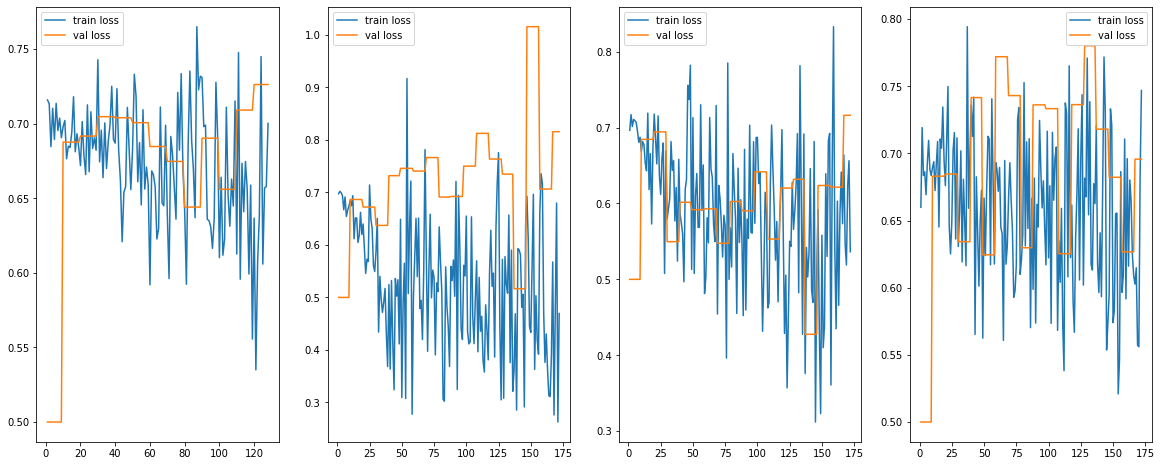

In [32]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(8)
num_ax = len(model_losses)
axis_list = []
for idx in range(1, num_ax+1):
    axis_list.append(fig.add_subplot(1, num_ax, idx)) 


for idx, losses in enumerate(model_losses):
    cur_ax = axis_list[idx]
    train_loss = losses["train"]
    val_loss = losses["val"]
    axis = range(1, len(train_loss)+1)
    cur_ax.plot(axis, train_loss,label='train loss')
    cur_ax.plot(axis, val_loss,label='val loss')
    cur_ax.legend()
plt.show()

In [33]:
from torchmetrics.functional import precision_recall

print(f"\n>>>Model tests for full data processing pipeline, one for each approach")
# Get test data loss and accuracy
for neg_polarity in models:
    print(f"testing individual model accuracy: current model has {neg_polarity} as negative class: ")

    net = models[neg_polarity]
    test_loader = test_loaders[neg_polarity]
    test_losses = []  # track loss
    num_correct = 0
    precision = []
    recall = []

    # init hidden state
    h = net.init_hidden(batch_size)

    net.eval()
    # iterate over test data
    for inputs, labels in test_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # get predicted outputs
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)
        # print(type(output))
        # print(output)

        # calculate loss
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer
        pred = pred.type(torch.IntTensor)

        batch_correct = labels.float().view_as(pred)
        batch_correct = batch_correct.type(torch.IntTensor)
        # print(type(batch_correct))
        # print(batch_correct)
        # compare predictions to true label
        correct_tensor = pred.eq(batch_correct)
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # print(pred.squeeze())
        cur_precision, cur_recall = precision_recall(pred.squeeze(),batch_correct.squeeze() , average='macro', num_classes=2)
        # print(cur_precision, cur_recall)
        precision.append(cur_precision.numpy())
        # print(type(cur_precision.numpy()))
        # print(cur_precision.numpy())
        recall.append(cur_recall.numpy())
        # print(type(cur_recall.numpy()))
        # print(cur_recall.numpy())
        num_correct += np.sum(correct)

    # avg test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    # accuracy over all test data
    test_acc = num_correct / len(test_loader.dataset)
    precision_all = np.mean(precision)
    recall_all = np.mean(recall)
    f1 = (2 * precision_all * recall_all) / (precision_all + recall_all)
    print("Test accuracy: {:.3f}".format(test_acc))
    print("Test precision: {:.3f}".format(precision_all))
    print("Test recall: {:.3f}".format(recall_all))
    print("Test f1: {:.3f}".format(f1))


>>>Model tests for full data processing pipeline, one for each approach
testing individual model accuracy: current model has polarity as negative class: 
Test loss: 0.664
Test accuracy: 0.594
Test precision: 0.637
Test recall: 0.587
Test f1: 0.611
testing individual model accuracy: current model has neutral as negative class: 
Test loss: 0.473
Test accuracy: 0.801
Test precision: 0.753
Test recall: 0.665
Test f1: 0.706
testing individual model accuracy: current model has pos as negative class: 
Test loss: 0.572
Test accuracy: 0.688
Test precision: 0.614
Test recall: 0.579
Test f1: 0.596
testing individual model accuracy: current model has neg as negative class: 
Test loss: 0.644
Test accuracy: 0.605
Test precision: 0.536
Test recall: 0.543
Test f1: 0.540


In [34]:
print(batch_size, lr, epochs)
neutral_net

16 0.0005 4


SentimentLSTM(
  (embedding): Embedding(5002, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)